In [ ]:
!apt install mumax3

!pip install pyovf



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libcudart11.0 libcufft10 libcurand10 libnvidia-compute-495
  libnvidia-compute-510 libnvidia-compute-535
The following NEW packages will be installed:
  libcudart11.0 libcufft10 libcurand10 libnvidia-compute-495
  libnvidia-compute-510 libnvidia-compute-535 mumax3
0 upgraded, 7 newly installed, 0 to remove and 38 not upgraded.
Need to get 162 MB of archives.
After this operation, 459 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 libcudart11.0 amd64 11.5.117~11.5.1-1ubuntu1 [178 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  libnvidia-compute-535 535.274.02-0ubuntu1 [36.9 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 libcufft10 amd64 11.1.1+~10.6.0.107~11.5.1-1ubuntu1 [70.4 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/

[mumax examples](https://mumax.github.io/examples.html)

Also added some simple functions from [mumax postprocessing workbook](https://colab.research.google.com/github/JeroenMulkers/mumax3-tutorial/blob/master/postprocessing.ipynb#scrollTo=W7Nn_7Gl0s66)

In [ ]:
from pandas import read_table

from subprocess import run, PIPE, STDOUT
from glob import glob
import os
from numpy import load
from IPython.display import display, Image

In [ ]:
def read_mumax3_table(filename):
    """Puts the mumax3 output table in a pandas dataframe"""

    table = read_table(filename)
    table.columns = ' '.join(table.columns).split()[1::2]

    return table

def read_mumax3_ovffiles(outputdir):
    """Load all ovffiles in outputdir into a dictionary of numpy arrays
    with the ovffilename (without extension) as key"""

    # convert all ovf files in the output directory to numpy files
    p = run(["mumax3-convert","-numpy",outputdir+"/*.ovf"], stdout=PIPE, stderr=STDOUT)
    if p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    # read the numpy files (the converted ovf files)
    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = os.path.splitext(os.path.basename(npyfile))[0]
        fields[key] = load(npyfile)

    return fields

def run_mumax3(script, name, verbose=False):
    """ Executes a mumax3 script and convert ovf files to numpy files

    Parameters
    ----------
      script:  string containing the mumax3 input script
      name:    name of the simulation (this will be the name of the script and output dir)
      verbose: print stdout of mumax3 when it is finished
    """
    if not os.path.exists("simulations"):
        os.mkdir("simulations")

    scriptfile = "simulations/" + name + ".txt"
    outputdir  = "simulations/" + name + ".out"

    # write the input script in scriptfile
    with open(scriptfile, 'w' ) as f:
        f.write(script)

    # call mumax3 to execute this script
    p = run(["mumax3","-f",scriptfile], stdout=PIPE, stderr=STDOUT)
    if verbose or p.returncode != 0:
        print(p.stdout.decode('UTF-8'))

    if os.path.exists(outputdir + "/table.txt"):
        table = read_mumax3_table(outputdir + "/table.txt")
    else:
        table = None

    fields = read_mumax3_ovffiles(outputdir)

    return table, fields

def convert_ovf_to_png(simulation_name):
    """Converts ovf to .png files within a given folder path. """

    run(["mumax3-convert", "-png", f"simulations/{simulation_name}.out/*.ovf", "-o", "output"], stdout=PIPE, stderr=STDOUT)

def display_folder(simulation_name):
    """Displays all .png files in the given folder path."""

    folder_path = f"simulations/{simulation_name}.out"

    listOfImageNames = os.listdir(path=folder_path)
    listOfImageNames = list(filter(lambda x:x[-4:]==".png", listOfImageNames))
    listOfImageNames.sort()

    for imageName in listOfImageNames:
        display(Image(filename=os.path.join(folder_path, imageName)))


#

Old code for record keeping

In [ ]:
# mumax_program = """
# setgridsize(128, 128, 1)
# setcellsize(2e-9, 2e-9, 2e-9)

# // Magnetisation saturation
# msat = 600e3
# aex = 12e-13
# // "Friction constant", how fast it will reach equilibrium
# alpha = 3

# N := 5
# size := 256e-9

# for i:=0; i<N; i=i+1{
#   interop := i/(N-1)
#   radius := size*interop/2
#   circle_x_position := abs(size)/2 - radius
#   circle_y_position := abs(size)/2 - radius
#   cross_width := size - radius*2

#   horisontal_rectangle := rect(size, cross_width)
#   vertical_rectangle := rect(cross_width, size)
#   edge_circle := circle(radius*2)
#   circles := edge_circle.transl(circle_x_position, circle_y_position, 0).add(edge_circle.transl(-circle_x_position, circle_y_position, 0)).add(edge_circle.transl(-circle_x_position, -circle_y_position, 0)).add(edge_circle.transl(circle_x_position, -circle_y_position, 0))

#   squircle := horisontal_rectangle.add(vertical_rectangle).add(circles)

#   setgeom(squircle)
#   m = uniform(1., .1, 0)
#   m = randommag()
#   m = vortex(1, 1)
#   minimize()

#   save(m)
# }
# """

# with open("simulation.mx3", "w") as file:
#   file.write(mumax_program)


# !rm -r /content/simulation.out
# !mumax3 simulation.mx3
# !mumax3-convert -png simulation.out/*.ovf -o output

# import os
# from IPython.display import Image, display





# simulation_outdir = "simulation.out"
# listOfImageNames = os.listdir(path=simulation_outdir)
# listOfImageNames = list(filter(lambda x:x[-4:]==".png", listOfImageNames))
# listOfImageNames.sort()

# for imageName in listOfImageNames:
#     display(Image(filename=os.path.join(simulation_outdir, imageName)))

# Areas of improvement for mumax magnetic simulation

## Grains

*   Add grains within a size range, for example between 3nm - 80nm in size
*   Most particles should be around the same size, but with smaller/larger particles
*   Using a random distribution of points and limiting the amount of points will shift the size distribution of particles. This can be adjusted to fit the experimental data. And will lead to more accurate simultions
*   Might be able to find the grain sizes using the AFM or TEM rather and plotting the sizes.
*   Also some articles suggesting one can get grain size distributions using TEM
    https://www.sciencedirect.com/science/article/pii/S0921452624001443
*   Need to fit voronoi particle sizes histogram to the measured histograms.
*   Makes for good simulations hopefully...
*   Voronoi gives approximatly gaussian distribution, where as the laguerre-voronoi gives a log normal distribution, more like actual grain size histogram distributions
https://www.mdpi.com/1996-1944/15/6/1996
*   When one has the data, make a fitted laugerre-voronoi distribution as well and put that into the shapes with the correct size and simulate magnetism.
*   Should also probably remove the outer layer of particles since they are not always representative since they become much larger...?
*   Also keep in mind that having the particle boarders in 2D is a major simplification, but one can assume that the particles in the material goes in the same direction when they have been projected in the xy plan even though the z component will most likely go in the opposite direction in the




In [ ]:
perfect_mumax_program = """
setgridsize(128, 128, 1)
setcellsize(2e-9, 2e-9, 2e-9)

// Magnetisation saturation
msat = 600e3
aex = 12e-13
// "Friction constant", how fast it will reach equilibrium
alpha = 3

N := 5
size := 256e-9

for i:=0; i<N; i=i+1{
  interop := i/(N-1)
  radius := size*interop/2
  circle_x_position := abs(size)/2 - radius
  circle_y_position := abs(size)/2 - radius
  cross_width := size - radius*2

  horisontal_rectangle := rect(size, cross_width)
  vertical_rectangle := rect(cross_width, size)
  edge_circle := circle(radius*2)
  circles := edge_circle.transl(circle_x_position, circle_y_position, 0).add(edge_circle.transl(-circle_x_position, circle_y_position, 0)).add(edge_circle.transl(-circle_x_position, -circle_y_position, 0)).add(edge_circle.transl(circle_x_position, -circle_y_position, 0))

  squircle := horisontal_rectangle.add(vertical_rectangle).add(circles)

  setgeom(squircle)
  m = uniform(1., .1, 0)
  m = randommag()
  m = vortex(1, 1)
  relax() // Obsolete when already minimized with vortex..?
  minimize()

  save(m)
}
"""

In [ ]:
amumax_program = """
// In nm, use int to prevent floating point error
side_len := 128

// In Aangstroems
cell_size := 5

setgridsize(side_len, side_len, 1)
setgridsize(128, 128, 1)
setcellsize(20e-10, 20e-10, 20e-10) // Aangstroem
// setcellsize(2e-9, 2e-9, 2e-9)

Msat  = 600e3
Aex   = 12e-13
alpha = 3

// Voronoi grains
// It was mentioned to us that the grains were most likely less than 4nm in size
grainSize  := 10e-9
randomSeed := 1234567
maxRegion  := 255
ext_makegrains(grainSize, maxRegion, randomSeed)

// assign random anisotropy per grain
// Anisotropy is a direction which the grain is more easily magnetized in..
for i:=0; i<maxRegion; i++ {
    axis1  := vector(randNorm(), randNorm(), randNorm())
    helper := vector(randNorm(), randNorm(), randNorm())
    axis2  := axis1.cross(helper)

    AnisC1.SetRegion(i, axis1)
    AnisC2.SetRegion(i, axis2)

    K := 1e5
    Kc1.SetRegion(i, K + randNorm() * 0.1 * K)
}

// reduce inter-grain exchange by 10%
for i:=0; i<maxRegion; i++ {
    for j:=i+1; j<maxRegion; j++ {
        ext_ScaleExchange(i, j, 0.9)
    }
}

// Loop over squircles
N := 5
size := 200e-9

for i:=0; i<N; i=i+1 {
    interop := i/(N-1)
    radius := size*interop/2
    circle_x_position := abs(size)/2 - radius
    circle_y_position := abs(size)/2 - radius
    cross_width := size - radius*2

    horisontal_rectangle := rect(size, cross_width)
    vertical_rectangle := rect(cross_width, size)
    edge_circle := circle(radius*2)
    circles := edge_circle.transl(
      circle_x_position, circle_y_position, 0).add(
        edge_circle.transl(-circle_x_position, circle_y_position, 0)).add(
          edge_circle.transl(-circle_x_position, -circle_y_position, 0)).add(
            edge_circle.transl(circle_x_position, -circle_y_position, 0))

    squircle := horisontal_rectangle.add(vertical_rectangle).add(circles)

    setgeom(squircle)
    m = randommag()

    // Most likely global minimum
    m = uniform(1., .1, 0)
    m = randommag()
    m = vortex(1, 1)
    relax() // Global minimum state, but very slow function..
    minimize()


    save(m)
}
save(regions)
save(Kc1)
save(AnisC1)
save(AnisC2)
"""

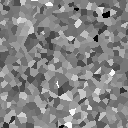

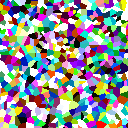

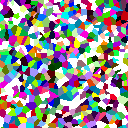

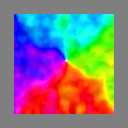

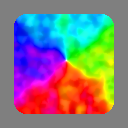

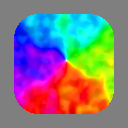

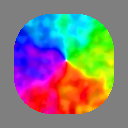

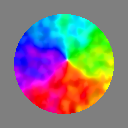

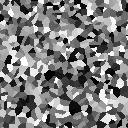

In [ ]:
# Run program
_, fields = run_mumax3(amumax_program, name="squircles_grain_simulations", verbose=False)

# Convert ovf files to png
convert_ovf_to_png("squircles_grain_simulations")

# Display simulation
display_folder("squircles_grain_simulations")

Notes here. Should maybe just have one voronoi tessalation diagram.
Also make a way for experiment borders to be put into this. also seems like there is some dithering of some sort of the border transfer regions. And i also assume that it is correct to start with a vortex, since that is the global minimum. And the minimize function can get stuck on a local minimum when using minimize... There is also a relax function runs for a little while and then stops, this does not go for a minima, so after the command is run one can run minimize afterwards...

Note on cellsize from lecture on mumax website.
In chiral ferro magnets, the magnetization might vary on a much smaller length scale than the exchange length. When choosing the cell size make sure that maxAngle is small enough during the simulation, of less than 0.35 rad. To get this do print(maxAngle) , if it is less than 0.35 rad then the cell size is ok.

Imageshape command, import black and white picture from real experiment
real := imageShape("drawing.png").scale(1,0.5,1.).transl(0, -400e-9,0)

https://colab.research.google.com/github/JeroenMulkers/mumax3-tutorial/blob/master/postprocessing.ipynb

In [ ]:
!pip install pyovf

In [ ]:
import pyovf

In [ ]:
# From chatGPT, want to measure how well the vortex vortexes in a better way ...

import numpy as np
import matplotlib.pyplot as plt

def analyze_vortex(magnetisation_x, magnetisation_y, center=None, n_radial_bins=50, min_magnitude=1e-6):
    """
    Analyze a 2D vortex given magnetisation_x and magnetisation_y.

    Parameters:
    - magnetisation_x, magnetisation_y: 2D arrays (ny, nx)
    - center: (x0, y0) tuple. If None, center is magnitude-weighted average
    - n_radial_bins: number of bins for radial profile
    - min_magnitude: threshold to ignore near-zero vectors

    Returns:
    - vortex_strength: average tangential component
    - vortex_evenness: std/mean of tangential component
    - strength_profile: radial profile (list)
    - r_bins: corresponding radial bins
    """

    ny, nx = magnetisation_x.shape
    X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

    # Compute magnitude
    magnitude = np.sqrt(magnetisation_x**2 + magnetisation_y**2)
    mask = magnitude < min_magnitude

    # Determine vortex center if not given
    if center is None:
        x0 = np.sum(X * magnitude) / np.sum(magnitude)
        y0 = np.sum(Y * magnitude) / np.sum(magnitude)
    else:
        x0, y0 = center

    dx = X - x0
    dy = Y - y0
    r = np.sqrt(dx**2 + dy**2)

    # Tangential unit vectors
    tangent_x = -dy / r
    tangent_y = dx / r
    r[r == 0] = np.nan  # avoid division by zero

    # Tangential component of the magnetization
    mt = magnetisation_x * tangent_x + magnetisation_y * tangent_y
    mt[mask] = np.nan  # ignore near-zero vectors

    # Overall vortex strength
    vortex_strength = np.nanmean(mt)

    # Evenness
    vortex_evenness = np.nanstd(mt) / np.nanmean(mt)

    # Radial profile
    r_bins = np.linspace(0, np.nanmax(r), n_radial_bins)
    strength_profile = np.array([
        np.nanmean(mt[(r >= r_bins[i]) & (r < r_bins[i+1])])
        for i in range(len(r_bins)-1)
    ])

    # Plot 2D tangential spin map
    plt.figure(figsize=(6,5))
    plt.imshow(mt, cmap='bwr', origin='lower')
    plt.colorbar(label='Tangential component')
    plt.title('Vortex tangential spin map')
    plt.show()

    # Plot radial profile
    plt.figure(figsize=(6,4))
    plt.plot(r_bins[:-1], strength_profile, '-o')
    plt.xlabel('Radius (pixels)')
    plt.ylabel('Tangential component')
    plt.title('Vortex radial strength profile')
    plt.grid(True)
    plt.show()

    return vortex_strength, vortex_evenness, strength_profile, r_bins

# --------------------------
# Example usage:
# vortex_strength, vortex_evenness, strength_profile, r_bins = analyze_vortex(magnetisation_x, magnetisation_y)
# print("Vortex strength:", vortex_strength)
# print("Vortex evenness:", vortex_evenness)




[np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.

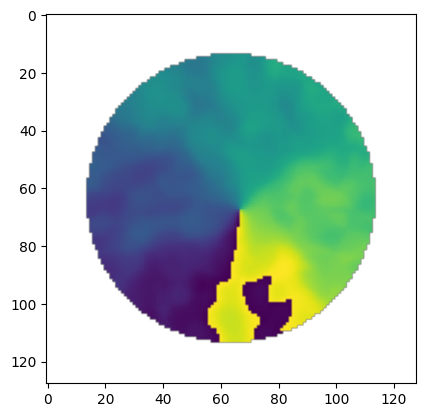

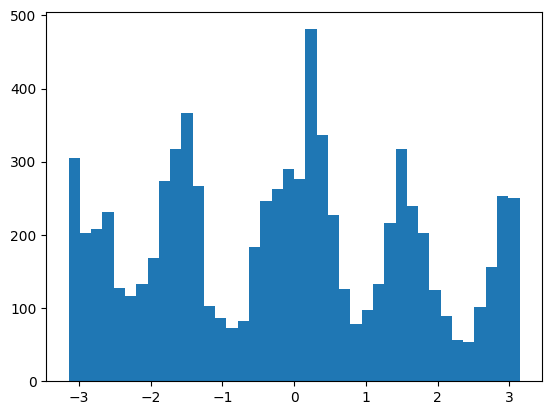

/tmp/ipython-input-3190794042.py:59: RuntimeWarning: Mean of empty slice
  np.nanmean(mt[(r >= r_bins[i]) & (r < r_bins[i+1])])


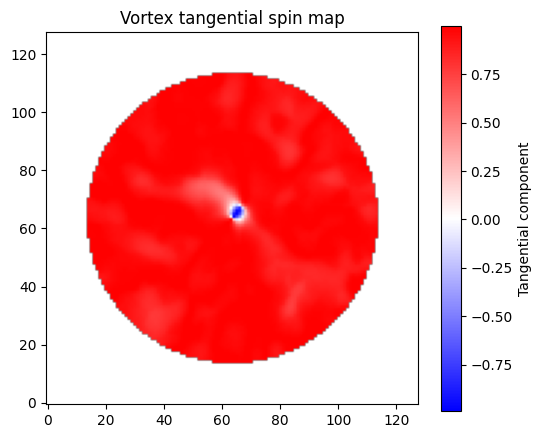

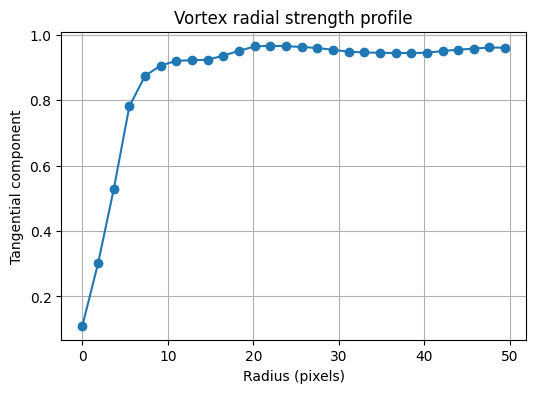

(np.float64(0.9419210682494603),
 np.float64(0.1151820493509754),
 array([0.11038394, 0.30147864, 0.52782443, 0.78156933, 0.87485752,
        0.90631204, 0.92074192, 0.92254796, 0.92411209, 0.93677124,
        0.95127047, 0.96483716, 0.96700565, 0.96554586, 0.96324643,
        0.96001891, 0.95457864, 0.94863798, 0.946481  , 0.94535998,
        0.94475428, 0.94464503, 0.94541387, 0.95075856, 0.95505966,
        0.95795229, 0.96171182, 0.96068026,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 array([ 0.        ,  1.83273176,  3.66546353,  5.49819529,  7.33092705,
         9.16365882, 10.99639058, 12.82912234, 14.66185411, 16.49458587,
        18.32731763, 20.1600494 , 21.99278116, 23.82551292, 25.65824469,
        27.49097645, 29.32370821, 31.15643998

In [ ]:
# TODO: Please look at the session 4 of this where they show how to do post processing of the .ovf file data,
# this shows pretty much all the  steps of how to show the data visually. And also how to load them
# also note, dont use the pyovf library. Just check the session :)

import pyovf
import numpy as np
import matplotlib.pyplot as plt

# Read OVF file
# print(os.listdir("simulation.out"))
# magnetisation_x, magnetisation_y, ovf_info = pyovf.read("simulation.out/m000000.ovf")
magnetisation_x, magnetisation_y, magnetisation_z = fields['m000004'][:,0,:,:]
print(list(magnetisation_x[0]))
print(magnetisation_y)

# def to_angle(x,y):
#   angle = np.arctan(np.divide(y,x))

#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == -1)] -= np.pi
#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == 1)] += np.pi
#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == 0)] = np.pi

#   return angle

magnitude = np.sqrt(magnetisation_x**2 + magnetisation_y**2)
mask = magnitude < 1e-6  # threshold for "no magnetization"

angle = np.arctan2(magnetisation_y, magnetisation_x)
angle[mask] = np.nan

plt.imshow(angle)
plt.show()
# plt.imshow(np.sqrt(magnetisation_x**2 + magnetisation_y**2))
# plt.show()

# TODO: Make histogram of this angle data. Might be a bad representation of the angle in a square,
# This should perhaps be a more continuos distribution??
plt.hist(angle[~mask].flatten(), bins=40)
plt.show()
# TODO: Make weighted bins based on magnitude, weighted will make the tops even taller.



# data_array will be a NumPy array. You can access its shape and other properties.
# print(data_array.shape)

# # Visualize a slice, for example, the z-component of magnetization
# # Assuming data_array has shape (nx, ny, nz, 3) for vector data (x, y, z)
# plt.imshow(data_array[:,:,0,2]) # Show z-component of the first slice
# plt.show()


analyze_vortex(magnetisation_x, magnetisation_y)


In [ ]:
# Run program
_, perfect_fields = run_mumax3(perfect_mumax_program, name="squircles_simulations", verbose=False)

# Convert ovf files to png
convert_ovf_to_png("squircles_simulations")

# # Display simulation
# display_folder("squircles_grain_simulations")

[np.float32(0.7071293), np.float32(0.75860125), np.float32(0.80899864), np.float32(0.85042286), np.float32(0.88259995), np.float32(0.9070793), np.float32(0.9256136), np.float32(0.93969655), np.float32(0.9504833), np.float32(0.9588312), np.float32(0.9653657), np.float32(0.97054136), np.float32(0.9746889), np.float32(0.9780505), np.float32(0.9808048), np.float32(0.98308504), np.float32(0.98499143), np.float32(0.9866002), np.float32(0.9879696), np.float32(0.989145), np.float32(0.99016184), np.float32(0.99104786), np.float32(0.9918255), np.float32(0.9925125), np.float32(0.99312335), np.float32(0.9936697), np.float32(0.9941611), np.float32(0.99460554), np.float32(0.9950097), np.float32(0.99537885), np.float32(0.9957177), np.float32(0.99603015), np.float32(0.99631935), np.float32(0.99658805), np.float32(0.99683857), np.float32(0.99707294), np.float32(0.9972928), np.float32(0.9974996), np.float32(0.99769455), np.float32(0.9978786), np.float32(0.9980527), np.float32(0.99821746), np.float32(0.9

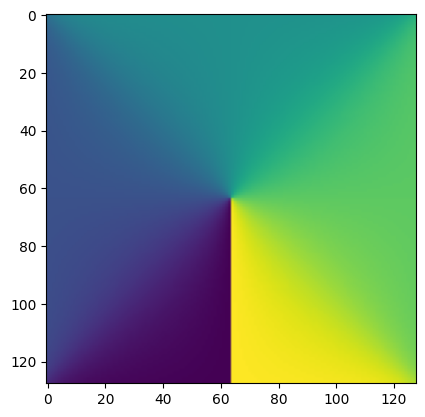

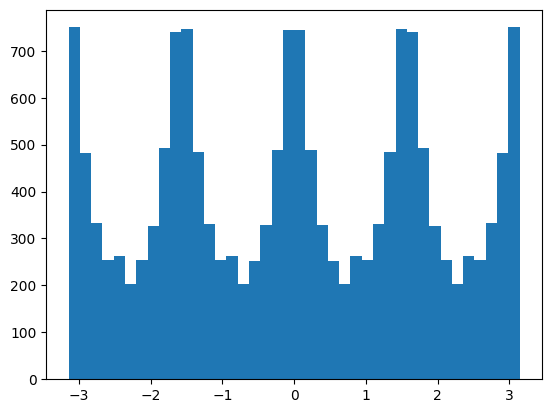

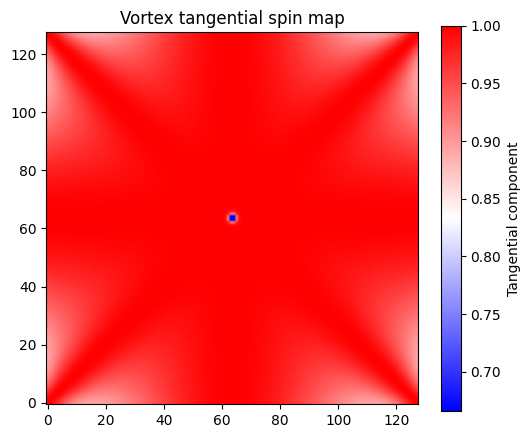

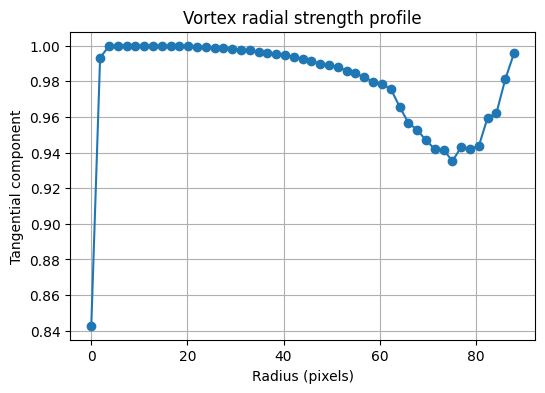

(np.float64(0.9823507506936469),
 np.float64(0.02422328120882647),
 array([0.84276493, 0.99316604, 0.99981947, 0.9999962 , 0.99999845,
        0.99999629, 0.99998499, 0.99995868, 0.9999127 , 0.99985388,
        0.99976507, 0.99963442, 0.99945426, 0.99925831, 0.99891913,
        0.99868687, 0.99826062, 0.99783786, 0.99734415, 0.99670903,
        0.9960076 , 0.99541076, 0.99467054, 0.9938746 , 0.9926319 ,
        0.99163615, 0.98975316, 0.98923551, 0.98785745, 0.98600303,
        0.98448234, 0.98220687, 0.97982659, 0.97826534, 0.97576967,
        0.96586549, 0.95669595, 0.95273576, 0.94696203, 0.94192089,
        0.94164195, 0.93518738, 0.94306119, 0.94218557, 0.94358692,
        0.9595905 , 0.96208888, 0.98107113, 0.99574767]),
 array([ 0.        ,  1.83270537,  3.66541074,  5.49811611,  7.33082148,
         9.16352685, 10.99623221, 12.82893758, 14.66164295, 16.49434832,
        18.32705369, 20.15975906, 21.99246443, 23.8251698 , 25.65787517,
        27.49058054, 29.32328591, 31.1559912

In [ ]:
magnetisation_x, magnetisation_y, magnetisation_z = perfect_fields['m000000'][:,0,:,:]
print(list(magnetisation_x[0]))
print(magnetisation_y)

# def to_angle(x,y):
#   angle = np.arctan(np.divide(y,x))

#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == -1)] -= np.pi
#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == 1)] += np.pi
#   angle[np.logical_and(np.sign(x) == -1, np.sign(y) == 0)] = np.pi

#   return angle

magnitude = np.sqrt(magnetisation_x**2 + magnetisation_y**2)
mask = magnitude < 1e-6  # threshold for "no magnetization"

angle = np.arctan2(magnetisation_y, magnetisation_x)
angle[mask] = np.nan

plt.imshow(angle)
plt.show()
# plt.imshow(np.sqrt(magnetisation_x**2 + magnetisation_y**2))
# plt.show()

# TODO: Make histogram of this angle data. Might be a bad representation of the angle in a square,
# This should perhaps be a more continuos distribution??
plt.hist(angle[~mask].flatten(), bins=40)
plt.show()

analyze_vortex(magnetisation_x,magnetisation_y)